<a href="https://colab.research.google.com/github/MoBanerjee/SC4001_Project/blob/main/ResNet_TripletLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective of Notebook
### The objective of this notebook is to implement and train a ResNet18-based model using triplet loss on the Flowers102 dataset to learn discriminative embeddings for image similarity tasks. The model's performance is evaluated through training, validation, and test accuracy to assess its effectiveness in distinguishing between similar and dissimilar images.


In [ ]:
# necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import random

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize the image to 224x224
    transforms.ToTensor(),          # convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # normalize using imagenet mean and std
])

In [ ]:
train_data = torchvision.datasets.Flowers102(root='./data', split='train', transform=transform, download=True)  # load the training data for Flowers102 with transformations
val_data = torchvision.datasets.Flowers102(root='./data', split='val', transform=transform, download=True)      # load the validation data for Flowers102 with transformations
test_data = torchvision.datasets.Flowers102(root='./data', split='test', transform=transform, download=True)    # load the test data for Flowers102 with transformations

### We implemented a triplet loss-based approach to train the ResNet-18 model for embedding learning. The custom TripletLoss class, with a defined margin, ensures that anchor-positive pairs are closer than anchor-negative pairs by the margin. We also created a TripletDataset class to construct anchor-positive-negative triplets from labeled data, essential for triplet loss training. Additionally, we modified the ResNet-18 model (ResNet18Triplet) by replacing its output layer to produce 128-dimensional embeddings, enabling the model to learn discriminative features for similarity-based tasks. These components together allow the model to effectively learn embeddings to distinguish between similar and dissimilar images.

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        # initialize the TripletLoss class, inheriting from nn.Module
        super(TripletLoss, self).__init__()
        
        # set the margin for the triplet loss, which defines the minimum required distance 
        # between the anchor-positive and anchor-negative pairs
        self.margin = margin
        
        # create an instance of PyTorch's TripletMarginLoss with the specified margin
        # TripletMarginLoss will calculate the triplet loss based on anchor, positive, and negative inputs
        self.loss_fn = nn.TripletMarginLoss(margin=self.margin)

    def forward(self, anchor, positive, negative):
        # define the forward pass for the loss function
        # calculate the triplet loss by comparing the anchor with positive and negative samples
        # the loss is minimized when the distance between anchor and positive is smaller
        # than the distance between anchor and negative by at least the margin
        return self.loss_fn(anchor, positive, negative)


In [ ]:
class TripletDataset(Dataset):
    def __init__(self, dataset):
        # initialize the TripletDataset class, inheriting from PyTorch's Dataset class

        self.dataset = dataset  # store the provided dataset
        self.labels = [label for _, label in dataset]  # extract labels from the dataset

        # create a dictionary mapping each label to a list of indices for that label
        # this will help in quickly finding positive samples for any anchor
        self.label_to_indices = {label: [] for label in set(self.labels)}
        for idx, label in enumerate(self.labels):
            self.label_to_indices[label].append(idx)  # add each index to the appropriate label's list

    def __getitem__(self, index):
        # define the behavior of the dataset when retrieving an item by index

        anchor, anchor_label = self.dataset[index]  # get the anchor sample and its label

        # select a positive sample (same label as the anchor)
        positive_index = index  # initialize positive index with the anchor index
        while positive_index == index:  # ensure the positive sample is different from the anchor
            positive_index = random.choice(self.label_to_indices[anchor_label])  # randomly select an index for a positive sample
        positive, _ = self.dataset[positive_index]  # retrieve the positive sample

        # select a negative sample (different label from the anchor)
        negative_label = random.choice(list(self.label_to_indices.keys()))  # randomly select a label for a negative sample
        while negative_label == anchor_label:  # ensure the negative label is different from the anchor's label
            negative_label = random.choice(list(self.label_to_indices.keys()))
        negative_index = random.choice(self.label_to_indices[negative_label])  # randomly select an index for the negative sample
        negative, _ = self.dataset[negative_index]  # retrieve the negative sample

        # return a triplet consisting of anchor, positive, and negative samples
        return anchor, positive, negative

    def __len__(self):
        # return the total number of samples in the dataset
        return len(self.dataset)


In [ ]:
class ResNet18Triplet(nn.Module):
    def __init__(self):
        # initialize the ResNet18Triplet class, inheriting from nn.Module
        super(ResNet18Triplet, self).__init__()

        # load a pre-trained ResNet-18 model
        self.resnet18 = models.resnet18(pretrained=True)

        # replace the fully connected (fc) layer of ResNet-18
        # the original fc layer outputs 1000 classes; here, we reduce it to output a 128-dimensional embedding
        # this 128-dimensional output will serve as an embedding for the triplet loss
        self.resnet18.fc = nn.Linear(512, 128)

    def forward(self, x):
        # define the forward pass through the model
        # pass the input x through the modified ResNet-18 to get a 128-dimensional embedding
        return self.resnet18(x)


In [ ]:
train_triplet_dataset = TripletDataset(train_data)  # create a TripletDataset using the training data
train_loader = DataLoader(train_triplet_dataset, batch_size=32, shuffle=True)  # load the TripletDataset into a DataLoader
# the DataLoader will return batches of triplets (anchor, positive, negative) with a batch size of 32
# shuffle=True randomizes the order of samples in each epoch for better training

In [ ]:
val_triplet_dataset = TripletDataset(val_data)  # create a TripletDataset using the validation data
val_loader = DataLoader(val_triplet_dataset, batch_size=32, shuffle=False)  # load the TripletDataset into a DataLoader
# the DataLoader will return batches of triplets (anchor, positive, negative) with a batch size of 32
# shuffle=False ensures the order of samples remains the same in each epoch, useful for consistent validation results

In [ ]:
test_triplet_dataset = TripletDataset(test_data)  # create a TripletDataset using the test data
test_loader = DataLoader(test_triplet_dataset, batch_size=32, shuffle=False)  # load the TripletDataset into a DataLoader
# the DataLoader will return batches of triplets (anchor, positive, negative) with a batch size of 32
# shuffle=False maintains the order of samples in each epoch, which is useful for consistent test evaluation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # set the device to GPU if available, otherwise CPU
model = ResNet18Triplet().to(device)  # initialize the ResNet18Triplet model and move it to the chosen device

In [ ]:
triplet_criterion = TripletLoss(margin=1.0)  # initialize the triplet loss criterion with a margin of 1.0
# this criterion will calculate the triplet loss by comparing anchor, positive, and negative embeddings
# the margin enforces that the distance between anchor and positive should be smaller than anchor and negative by at least 1.0

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)  # initialize the Adam optimizer with a learning rate of 0.001

In [ ]:
def train_model_triplet(model, criterion, optimizer, num_epochs=100, patience=5):
    best_val_acc = 0.0  # initialize the best validation accuracy
    counter = 0  # counter for early stopping
    device = next(model.parameters()).device  # get the device from the model parameters

    # lists to store training and validation history
    train_loss_history, train_acc_history = [], []
    val_loss_history, val_acc_history = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()  # set the model to training mode
        running_loss = 0.0  # track total loss for the epoch
        correct_train = 0  # track correct training triplets
        total_train = 0  # track total number of training samples

        # iterate over batches of triplets (anchor, positive, negative)
        for anchor, positive, negative in train_loader:
            # move each input to the specified device (CPU or GPU)
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            optimizer.zero_grad()  # clear the gradients for the optimizer

            # forward pass for each component of the triplet
            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)

            # calculate triplet loss
            loss = criterion(anchor_output, positive_output, negative_output)
            loss.backward()  # backpropagation to compute gradients
            optimizer.step()  # update model parameters

            running_loss += loss.item()  # accumulate loss for this batch

            # calculate distances between anchor-positive and anchor-negative
            dist_pos = (anchor_output - positive_output).pow(2).sum(1)
            dist_neg = (anchor_output - negative_output).pow(2).sum(1)
            # count correct predictions where positive is closer to anchor than negative
            correct_train += (dist_pos < dist_neg).sum().item()
            total_train += anchor.size(0)  # update total count of samples

        # calculate average training loss and accuracy for the epoch
        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_loss_history.append(train_loss)  # record training loss
        train_acc_history.append(train_acc)  # record training accuracy

        # validate the model on the validation set
        val_loss, val_acc = validate_model_triplet(model, criterion, device)
        val_loss_history.append(val_loss)  # record validation loss
        val_acc_history.append(val_acc)  # record validation accuracy

        # print epoch summary
        print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

        # save the best model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            torch.save(best_model_state, 'Best_ResNet_TripletLoss.pth')  # save the model state
            counter = 0  # reset the early stopping counter
        else:
            counter += 1  # increment the early stopping counter

        # check if early stopping is triggered
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}. No improvement in validation accuracy for {patience} consecutive epochs.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history  # return training and validation history


In [ ]:
def validate_model_triplet(model, criterion, device):
    model.eval()  # set the model to evaluation mode
    running_loss = 0.0  # track total validation loss
    correct_val = 0  # track correct validation triplets
    total_val = 0  # track total number of validation samples

    with torch.no_grad():  # disable gradient calculation for validation
        # iterate over batches of triplets (anchor, positive, negative) in the validation set
        for anchor, positive, negative in val_loader:
            # move each input to the specified device (CPU or GPU)
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            # forward pass for each component of the triplet
            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)

            # calculate triplet loss
            loss = criterion(anchor_output, positive_output, negative_output)
            running_loss += loss.item()  # accumulate loss for this batch

            # calculate distances between anchor-positive and anchor-negative
            dist_pos = (anchor_output - positive_output).pow(2).sum(1)
            dist_neg = (anchor_output - negative_output).pow(2).sum(1)
            # count correct predictions where positive is closer to anchor than negative
            correct_val += (dist_pos < dist_neg).sum().item()
            total_val += anchor.size(0)  # update total count of samples

    # calculate average validation loss and accuracy
    val_loss = running_loss / len(val_loader)
    val_acc = correct_val / total_val
    return val_loss, val_acc  # return validation loss and accuracy

In [ ]:
def test_model_triplet(model):
    model.eval()  # set the model to evaluation mode

    correct = 0  # track correct test triplets
    total = 0  # track total number of test samples

    with torch.no_grad():  # disable gradient calculation for testing
        # iterate over batches of triplets (anchor, positive, negative) in the test set
        for anchor, positive, negative in test_loader:
            # move each input to the specified device (CPU or GPU)
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            # forward pass for each component of the triplet
            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)

            # calculate distances between anchor-positive and anchor-negative
            dist_pos = (anchor_output - positive_output).pow(2).sum(1)
            dist_neg = (anchor_output - negative_output).pow(2).sum(1)
            # count correct predictions where positive is closer to anchor than negative
            correct += (dist_pos < dist_neg).sum().item()
            total += anchor.size(0)  # update total count of samples

    # calculate test accuracy as the ratio of correct predictions to total samples
    test_acc = correct / total
    return test_acc  # return the test accuracy

In [ ]:
# train the model using the triplet loss criterion and optimizer for 100 epochs
# the function returns training and validation loss and accuracy history
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model_triplet(model, triplet_criterion, optimizer, num_epochs=100)

Epoch [1/100], Train Loss: 0.6676, Train Accuracy: 0.8127, Validation Loss: 1.3563, Validation Accuracy: 0.7696
Epoch [2/100], Train Loss: 0.6194, Train Accuracy: 0.7843, Validation Loss: 0.5759, Validation Accuracy: 0.7941
Epoch [3/100], Train Loss: 0.5355, Train Accuracy: 0.7912, Validation Loss: 0.6525, Validation Accuracy: 0.7676
Epoch [4/100], Train Loss: 0.5962, Train Accuracy: 0.7657, Validation Loss: 0.5707, Validation Accuracy: 0.7755
Epoch [5/100], Train Loss: 0.4833, Train Accuracy: 0.8039, Validation Loss: 0.5293, Validation Accuracy: 0.7882
Epoch [6/100], Train Loss: 0.5161, Train Accuracy: 0.8010, Validation Loss: 0.5583, Validation Accuracy: 0.7853
Epoch [7/100], Train Loss: 0.5093, Train Accuracy: 0.7980, Validation Loss: 0.5503, Validation Accuracy: 0.7941
Early stopping at epoch 7. No improvement in validation accuracy for 5 consecutive epochs.


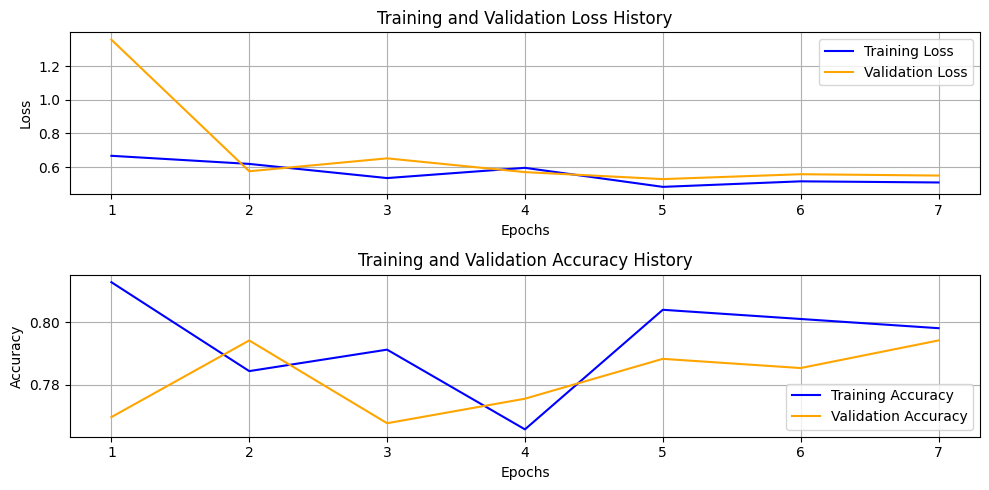

In [ ]:
# cell for plotting train and validation metrics
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'orange', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(epochs, train_acc_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc_history, 'orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# evaluate model on test dataset
test_acc=test_model_triplet(model)

In [ ]:
print(f'Test Accuracy: {test_acc}%')

Test Accuracy: 0.7754106358757522%


## Analysis of Results
### The training and validation loss curves demonstrate stability with minor fluctuations, and both accuracy curves follow a similar pattern, indicating consistent learning. The model achieves a test accuracy of approximately 77.5%, reflecting a reasonable performance in distinguishing between similar and dissimilar images based on the learned embeddings.